# SETUP

In [1]:
import sys
sys.path.insert(0,'..')
from IPython.display import display, HTML
if not sys.warnoptions:
    import warnings
from matplotlib.ticker import PercentFormatter
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.constants as const
from astropy.cosmology import WMAP9 as cosmo
from datetime import datetime
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from matplotlib.cm import register_cmap
from matplotlib_venn import venn3

from numpy.lib.stride_tricks import as_strided
import pickle
from scipy import stats
from datetime import datetime
from spectral_cube import SpectralCube

## Plot Combined Scores

In [2]:
freq_dict = {"mask_1245mosB.fits": [1401252439.970,1425092772.001],
"mask_1245mosC.fits": [1381037599.970,1404877932.001],
"mask_1245mosD.fits": [1360822751.970,1384663084.001],
"mask_1245mosE.fits": [1340607911.970,1364448244.001],
"mask_1245mosF.fits": [1320393067.970,1344233400.001],
"mask_1245mosG.fits": [1300178221.970,1324018554.001],
"mask_1245mosH.fits": [1279963378.910,1303803710.941],
"mask_1353mosB.fits": [1401179199.970,1425019532.001],
"mask_1353mosC.fits": [1380964351.970,1404804684.001],
"mask_1353mosD.fits": [1360749511.970,1384589844.001],

"mask_1353mosE.fits": [1340534667.970,1364375000.001],
"mask_1353mosF.fits": [1320319823.970,1344160156.001],
"mask_1353mosG.fits": [1300104979.970,1323945312.001],
"mask_1353mosH.fits": [1279890136.720,1303730468.751]}
df = pd.DataFrame(freq_dict.values(), columns=[["freq_1", "freq_2"]])
df["file_names"] = freq_dict.keys()
df["freq_1_round"] = np.round(df['freq_1']*1e-6).astype(int).astype(str)
df["freq_2_round"] = np.round(df['freq_2']*1e-6).astype(int).astype(str)
df['freq_labels'] = df[['freq_1_round', 'freq_2_round']].agg('-'.join, axis=1)
df.columns = df.columns.map(''.join)
df['mos_name'] = df.file_names.str.replace("mask_", "").str.replace(".fits", "")

/tmp/ipykernel_321/4228116216.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  df['mos_name'] = df.file_names.str.replace("mask_", "").str.replace(".fits", "")


In [3]:
with open("../results/mto_performance_loudInput.txt", "rb") as fp:
    mto_time = pickle.load(fp)
mto_time_df = pd.DataFrame([(freq_dict[i.split("/")[-1].replace("loud", "mask")][0], m) for i,m in mto_time.items()], columns=['freq_1', 'time_taken'])
with open("../results/vnet_performance_saved_models_28052021_101114_loud_14.txt", "rb") as fp:
    vnet_time = pickle.load(fp)
vnet_time_df = pd.DataFrame([(freq_dict[i.split("/")[-1].replace("loud", "mask")][0], m) for i,m in vnet_time.items()], columns=['freq_1', 'time_taken'])
with open("../results/sofia_performance_loudInput.txt", "rb") as fp:
    sofia_time = pickle.load(fp)
sofia_time_df = pd.DataFrame([(freq_dict[i.split("/")[-1].replace("loud", "mask")][0], m) for i,m in sofia_time.items()], columns=['freq_1', 'time_taken'])

time_df = pd.DataFrame([sofia_time_df.time_taken.mean(), mto_time_df.time_taken.mean(), vnet_time_df.time_taken.mean()], columns=["Elapsed Time"])
time_df.index = ["SoFiA", "MTO", "V-NET"]
time_df

,Elapsed Time
SoFiA,3439.489969
MTO,9524.675109
V-NET,23644.802931


## Create catalog of sources and their attributes

In [4]:
mto_cat_df = pd.read_csv("../results/loud_MTO_catalog.txt", index_col=0)
vnet_cat_df = pd.read_csv("../results/loud_VNET_catalog.txt", index_col=0)
sofia_cat_df = pd.read_csv("../results/loud_SOFIA_catalog.txt", index_col=0)
mask_cat_df = pd.read_csv("../results/loud_MASK_catalog.txt", index_col=0)

In [5]:
mask_cat_df["mos_name"] = mask_cat_df.file.str.split("_", expand=True)[1].str.replace(".fits", "")
sofia_cat_df["mos_name"] = sofia_cat_df.file.str.split("_", expand=True)[3]
mto_cat_df["mos_name"] = mto_cat_df.file.str.split("_", expand=True)[3].str.replace(".fits", "")
vnet_cat_df["mos_name"] = vnet_cat_df.file.str.split("_", expand=True)[4].str.replace(".fits", "")

/tmp/ipykernel_321/1959253273.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  mask_cat_df["mos_name"] = mask_cat_df.file.str.split("_", expand=True)[1].str.replace(".fits", "")
/tmp/ipykernel_321/1959253273.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  mto_cat_df["mos_name"] = mto_cat_df.file.str.split("_", expand=True)[3].str.replace(".fits", "")
/tmp/ipykernel_321/1959253273.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  vnet_cat_df["mos_name"] = vnet_cat_df.file.str.split("_", expand=True)[4].str.replace(".fits", "")


In [6]:
d_width = 0.001666666707*u.deg
mto_cat_df["nx_kpc"] = mto_cat_df.dist*np.tan(np.deg2rad(d_width*mto_cat_df.nx))*1e3
mto_cat_df["ny_kpc"] = mto_cat_df.dist*np.tan(np.deg2rad(d_width*mto_cat_df.ny))*1e3
sofia_cat_df["nx_kpc"] = sofia_cat_df.dist*np.tan(np.deg2rad(d_width*sofia_cat_df.nx))*1e3
sofia_cat_df["ny_kpc"] = sofia_cat_df.dist*np.tan(np.deg2rad(d_width*sofia_cat_df.ny))*1e3
mask_cat_df["nx_kpc"] = mask_cat_df.dist*np.tan(np.deg2rad(d_width*mask_cat_df.nx))*1e3
mask_cat_df["ny_kpc"] = mask_cat_df.dist*np.tan(np.deg2rad(d_width*mask_cat_df.ny))*1e3
vnet_cat_df["nx_kpc"] = vnet_cat_df.dist*np.tan(np.deg2rad(d_width*vnet_cat_df.nx))*1e3
vnet_cat_df["ny_kpc"] = vnet_cat_df.dist*np.tan(np.deg2rad(d_width*vnet_cat_df.ny))*1e3

In [7]:
def evaluate(output_df, gt_df, mos_name, verbose=False):
    seg_df = output_df[output_df.mos_name == mos_name]
    tp = len(seg_df[seg_df.true_positive_mocks])
    fp = len(seg_df) - tp #- len(seg_df[seg_df.true_positive_real])
    fn = len(gt_df[gt_df.mos_name == mos_name]) - tp
    try:
        r = tp / (tp + fn)
    except ZeroDivisionError:
        r = 0
    try:
        p = tp / (tp + fp)
    except ZeroDivisionError:
        p = 0
    try:
        f_score = 2 * ((p * r) / (p + r))
    except ZeroDivisionError:
        f_score = 0
    um_score = np.mean((((seg_df.area_gt - seg_df.overlap_area) * seg_df.overlap_area)/seg_df.area_gt)/seg_df.detection_size)
    om_score = np.mean((((seg_df.area - seg_df.overlap_area) * seg_df.overlap_area)/seg_df.area)/seg_df.detection_size)
    area_score = np.sqrt((om_score ** 2) + (um_score ** 2))
    combined_one = np.sqrt((f_score ** 2) + (area_score ** 2))
    combined_two = np.cbrt((1 - om_score) * (1 - um_score) * f_score)
    if verbose:
        print("OUTSTAT True positive: ", tp)
        print("OUTSTAT False negative: ", fn)
        print("OUTSTAT False positive: ", fp)
        print("OUTSTAT Recall: ", r)
        print("OUTSTAT Precision: ", p)
        print("OUTSTAT F score: ", f_score)
        print("OUTSTAT Undermerging score:", um_score)
        print("OUTSTAT Overmerging score:", om_score)
        print("OUTSTAT Total area score:", area_score)
        print("OUTSTAT Combined A:", combined_one)
        print("OUTSTAT Combined B:", combined_two)
        
    return [mos_name, tp, fp, fn, r, p, f_score, um_score, om_score, area_score, combined_one, combined_two]

In [8]:
def make_eval_df(source_props_df, mask_cat_df):
    eval_df = pd.DataFrame(columns=['mos_name', 'tp', 'fp', 'fn', 'recall', 'precision', 'f_score', 'um', 'om',
           'area_score', 'combined_one', 'combined_two'])
    for mos_name in mask_cat_df.mos_name.unique():
        eval_df = eval_df.append(pd.Series(evaluate(source_props_df, mask_cat_df, mos_name), index = eval_df.columns), ignore_index=True)
    eval_df = pd.merge(df[['mos_name', 'freq_1', 'freq_labels']], eval_df, on="mos_name", how="outer")
    return eval_df

# Experiment 1

## VNET learning

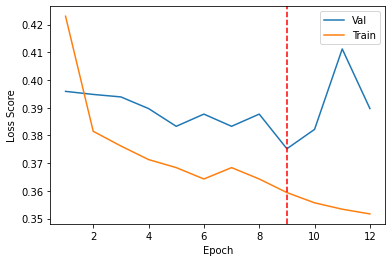

In [9]:
summary_df = pd.read_csv("loss.csv")
plt.plot(summary_df.epoch[summary_df.loss_type=="val"], summary_df.loss[summary_df.loss_type=="val"], label="Val")
plt.plot(summary_df.epoch[summary_df.loss_type=="train"], summary_df.loss[summary_df.loss_type=="train"], label="Train")
plt.xlabel("Epoch")
plt.ylabel("Loss Score")
plt.axvline(x=9, linestyle='--', color='r')
plt.legend()
plt.show()

## Find Real detections
Take cross-referenced (with optical) sources out of evaluation


Add filters (set to false detections) - and remove really false detections from optical overlay to save time:
- all spatial distributions below beam size and above 0.3Mpc
- all spectral filters lower than 7km/s and above 750 km/s 

In [10]:
noise_res = [(15*u.arcsec).to(u.deg), (25*u.arcsec).to(u.deg)]
kpc_lim = [0, 300]
n_vel_lim = [7, 750]

In [11]:
cond = (
    (mask_cat_df.nx*d_width < noise_res[0]) | (mask_cat_df.ny*d_width < noise_res[1]) | 
    (mask_cat_df.ny_kpc > kpc_lim[1]) | (mask_cat_df.nx_kpc > kpc_lim[1]) |
    (mask_cat_df.n_vel > n_vel_lim[1]) | (mask_cat_df.n_vel < n_vel_lim[0])
)
print(len(mask_cat_df[cond]), "false positives flagged out of ", len(mask_cat_df))


0 false positives flagged out of  4272


In [12]:
cond1 = (
    (mto_cat_df.nx*d_width < noise_res[0]) | (mto_cat_df.ny*d_width < noise_res[1]) | 
    (mto_cat_df.ny_kpc > kpc_lim[1]) | (mto_cat_df.nx_kpc > kpc_lim[1]) |
    (mto_cat_df.n_vel > n_vel_lim[1]) | (mto_cat_df.n_vel < n_vel_lim[0])
)
print(len(mto_cat_df[cond1 & mto_cat_df.true_positive_real]), "false positives real sources flagged out of ", len(mto_cat_df[mto_cat_df.true_positive_real]))
print(len(mto_cat_df[cond1 & mto_cat_df.true_positive_mocks]), "false positives mock sources flagged out of ", len(mto_cat_df[mto_cat_df.true_positive_mocks]))
filtered_mto = mto_cat_df[~cond1 | mto_cat_df.true_positive_mocks]
# mto_cat_df.loc[cond1, 'true_positive_real'] = False
# mto_cat_df.loc[cond1, 'true_positive_mocks'] = False


7926 false positives real sources flagged out of  13868
61 false positives mock sources flagged out of  1573


In [13]:
cond2 = (
    (sofia_cat_df.nx*d_width < noise_res[0]) | (sofia_cat_df.ny*d_width < noise_res[1]) | 
    (sofia_cat_df.ny_kpc > kpc_lim[1]) | (sofia_cat_df.nx_kpc > kpc_lim[1]) |
    (sofia_cat_df.n_vel > n_vel_lim[1]) | (sofia_cat_df.n_vel < n_vel_lim[0])
)
print(len(sofia_cat_df[cond2 & sofia_cat_df.true_positive_real]), "false positives real sources flagged out of ", len(sofia_cat_df[sofia_cat_df.true_positive_real]))
print(len(sofia_cat_df[cond2 & sofia_cat_df.true_positive_mocks]), "false positives mock sources flagged out of ", len(sofia_cat_df[sofia_cat_df.true_positive_mocks]))
filtered_sofia = sofia_cat_df[~cond2 | sofia_cat_df.true_positive_mocks]
# sofia_cat_df.loc[cond2, 'true_positive_real'] = False
# sofia_cat_df.loc[cond2, 'true_positive_mocks'] = False


65 false positives real sources flagged out of  269
3 false positives mock sources flagged out of  2064


In [14]:
cond3 = (
    (vnet_cat_df.nx*d_width < noise_res[0]) | (vnet_cat_df.ny*d_width < noise_res[1]) | 
    (vnet_cat_df.ny_kpc > kpc_lim[1]) | (vnet_cat_df.nx_kpc > kpc_lim[1]) |
    (vnet_cat_df.n_vel > n_vel_lim[1]) | (vnet_cat_df.n_vel < n_vel_lim[0])
)
print(len(vnet_cat_df[cond3 & vnet_cat_df.true_positive_real]), "false positives real sources flagged out of ", len(vnet_cat_df[vnet_cat_df.true_positive_real]))
print(len(vnet_cat_df[cond3 & vnet_cat_df.true_positive_mocks]), "false positives mock sources flagged out of ", len(vnet_cat_df[vnet_cat_df.true_positive_mocks]))
filtered_vnet = vnet_cat_df[~cond3 | vnet_cat_df.true_positive_mocks]

# vnet_cat_df.loc[cond3, 'true_positive_real'] = False
# vnet_cat_df.loc[cond3, 'true_positive_mocks'] = False


299 false positives real sources flagged out of  452
1 false positives mock sources flagged out of  2489


In [122]:
full_sofia_df = make_eval_df(sofia_cat_df, mask_cat_df)
full_mto_df = make_eval_df(mto_cat_df, mask_cat_df)
full_vnet_df = make_eval_df(vnet_cat_df, mask_cat_df)
sf = full_sofia_df.sort_values('freq_labels')[['mos_name', 'freq_labels', 'tp', 'fp']]
mt = full_mto_df.sort_values('freq_labels')[['mos_name', 'freq_labels', 'tp', 'fp']]
vnet = full_vnet_df.sort_values('freq_labels')[['mos_name', 'freq_labels', 'tp', 'fp']]
vnet.columns = ["mos_name", "freq_labels", "tp_VNET", "fp_VNET"]
sum_fp = pd.merge(sf, mt, on=["mos_name", "freq_labels"], suffixes=("_SoFiA", "_MTO"))
sum_fp = pd.merge(sum_fp, vnet, on=["mos_name", "freq_labels"])
real_catalog = pd.read_csv("../fp_to_drop.csv")
new_sof = pd.merge(sofia_cat_df, real_catalog[real_catalog.method=="sofia"], on=["mos_name", "label"], how="left")
new_vnet = pd.merge(vnet_cat_df, real_catalog[real_catalog.method=="vnet"], on=["mos_name", "label"], how="left")
new_mto = pd.merge(mto_cat_df, real_catalog[real_catalog.method=="mto"], on=["mos_name", "label"], how="left")
# for i, row in new_vnet[~new_vnet.type.isnull()][['mos_name', 'max_loc', 'type']].iterrows():
#     new_mto.loc[(new_mto.mos_name==row.mos_name) & (new_mto.max_loc==row.max_loc), "type"] = row.type
# for i, row in new_sof[~new_sof.type.isnull()][['mos_name', 'max_loc', 'type']].iterrows():
#     new_mto.loc[(new_mto.mos_name==row.mos_name) & (new_mto.max_loc==row.max_loc), "type"] = row.type
new_sum_fp = pd.merge(sum_fp, new_sof[~new_sof.type.isnull()][['mos_name', 'type']].groupby(['mos_name']).count(), on="mos_name", how='left')
new_sum_fp.columns = ['mos_name', 'freq_labels', 'tp_SoFiA', 'fp_SoFiA', 'tp_MTO', 'fp_MTO', 'tp_VNET', 'fp_VNET', 'real_SoFiA']
new_sum_fp = pd.merge(new_sum_fp, new_vnet[~new_vnet.type.isnull()][['mos_name', 'type']].groupby(['mos_name']).count(), on="mos_name", how='left')
new_sum_fp.columns = ['mos_name', 'freq_labels', 'tp_SoFiA', 'fp_SoFiA', 'tp_MTO', 'fp_MTO', 'tp_VNET', 'fp_VNET', 'real_SoFiA', 'real_VNET']
new_sum_fp = pd.merge(new_sum_fp, new_mto[~new_mto.type.isnull()][['mos_name', 'type']].groupby(['mos_name']).count(), on="mos_name", how='left')
new_sum_fp.columns = ['mos_name', 'freq_labels', 'tp_SoFiA', 'fp_SoFiA', 'tp_MTO', 'fp_MTO', 'tp_VNET', 'fp_VNET', 'real_SoFiA', 'real_VNET', 'real_MTO']

new_sum_fp['SoFiA Nonsense'] = new_sum_fp.fp_SoFiA-new_sum_fp.real_SoFiA
new_sum_fp.loc[new_sum_fp.real_SoFiA.isnull(), 'SoFiA Nonsense'] = new_sum_fp.fp_SoFiA
new_sum_fp.loc[new_sum_fp.real_SoFiA.isnull(), 'real_SoFiA'] = 0
new_sum_fp['SoFiA % real'] = new_sum_fp.real_SoFiA*100/(new_sum_fp.fp_SoFiA)
new_sum_fp['VNET Nonsense'] = new_sum_fp.fp_VNET-new_sum_fp.real_VNET
new_sum_fp.loc[new_sum_fp.real_VNET.isnull(), 'VNET Nonsense'] = new_sum_fp.fp_VNET
new_sum_fp.loc[new_sum_fp.real_VNET.isnull(), 'real_VNET'] = 0
new_sum_fp['VNET % real'] = new_sum_fp.real_VNET*100/(new_sum_fp.fp_VNET)

new_sum_fp['MTO Nonsense'] = new_sum_fp.fp_MTO-new_sum_fp.real_MTO
new_sum_fp.loc[new_sum_fp.real_MTO.isnull(), 'MTO Nonsense'] = new_sum_fp.fp_MTO
new_sum_fp.loc[new_sum_fp.real_MTO.isnull(), 'real_MTO'] = 0
new_sum_fp['MTO % real'] = new_sum_fp.real_MTO*100/(new_sum_fp.fp_MTO)

new_sum_fp = pd.merge(mask_cat_df.groupby("mos_name").count().label, new_sum_fp, on="mos_name")
# new_sum_fp.columns = ['mos_name', 'all mocks', 'freq_labels', 'SoFiA mocks', 'SoFiA_fp', 'MTO mocks', 'MTO_fp', 'SoFiA real', 'SoFiA Nonsense', 'SoFiA % real']
new_sum_fp['SoFiA % mocks detected'] = new_sum_fp.tp_SoFiA*100/new_sum_fp.label
new_sum_fp['VNET % mocks detected'] = new_sum_fp.tp_VNET*100/new_sum_fp.label
new_sum_fp['MTO % mocks detected'] = new_sum_fp.tp_MTO*100/new_sum_fp.label
new_sum_fp.sort_values('freq_labels', inplace=True)
new_sum_fp.set_index('freq_labels', inplace=True)
new_sum_fp[['mos_name', 'tp_SoFiA', 'tp_VNET', 'tp_MTO', 'real_SoFiA', 'real_VNET', 'real_MTO', 'SoFiA Nonsense', 'VNET Nonsense', 'MTO Nonsense']]

,mos_name,tp_SoFiA,tp_VNET,tp_MTO,real_SoFiA,real_VNET,real_MTO,SoFiA Nonsense,VNET Nonsense,MTO Nonsense
freq_labels,,,,,,,,,,
1280-1304,1245mosH,4,19,10,0.0,1,0.0,20,239,11052
1280-1304,1353mosH,2,33,20,0.0,19,0.0,26,538,12320
1300-1324,1245mosG,33,38,5,40.0,15,3.0,106.0,34,485.0
1300-1324,1353mosG,32,95,11,15.0,12,9.0,99.0,40,3284.0
1320-1344,1245mosF,73,85,25,12.0,2,0.0,16.0,21,550
1320-1344,1353mosF,20,62,9,8.0,6,1.0,35.0,26,1765.0
1341-1364,1245mosE,112,129,41,61.0,19,8.0,38.0,52,760.0
1341-1364,1353mosE,99,200,53,31.0,13,11.0,36.0,60,2054.0
1361-1385,1245mosD,180,229,110,41.0,21,13.0,9.0,47,828.0


- MTO very sensitive to diagonal lines

In [19]:
# new_sum_fp[['SoFiA % real', 'VNET % real', 'MTO % real', 'SoFiA % mocks detected', 'VNET % mocks detected', 'MTO % mocks detected']
#           ].plot(color=[u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#1f77b4', u'#ff7f0e', u'#2ca02c'], style=['-', '-', '-', '--', '--', '--'])
# plt.xticks(rotation=15)
# plt.xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
# plt.ylabel("Percentage %")
# plt.show()

### Try to cross-match real detections along methods

In [129]:
mock_sum = new_sum_fp[new_sum_fp.mos_name.str.contains("1353")][['mos_name', 'tp_SoFiA', 'tp_MTO', 'tp_VNET']]
mock_sum = pd.merge(df[['mos_name', 'freq_labels']], pd.merge(mock_sum, mask_cat_df[mask_cat_df.mos_name.str.contains("1353")].groupby("mos_name").count().file, on="mos_name", how='left'), on="mos_name", how="right")
mock_sum.columns = ['mos_name', 'Frequency Range', 'SoFiA mock detections', 'MTO mock detections', 'VNET mock detections', 'Total mock sources']
mock_sum[['Frequency Range', 'SoFiA mock detections', 'MTO mock detections', 'VNET mock detections', 'Total mock sources']].to_latex(index=False)

'\\begin{tabular}{llllr}\n\\toprule\nFrequency Range & SoFiA mock detections & MTO mock detections & VNET mock detections &  Total mock sources \\\\\n\\midrule\n      1280-1304 &                     2 &                  20 &                   33 &                 211 \\\\\n      1300-1324 &                    32 &                  11 &                   95 &                 355 \\\\\n      1320-1344 &                    20 &                   9 &                   62 &                 192 \\\\\n      1341-1364 &                    99 &                  53 &                  200 &                 367 \\\\\n      1361-1385 &                   193 &                  67 &                  257 &                 316 \\\\\n      1381-1405 &                   264 &                 222 &                  266 &                 280 \\\\\n      1401-1425 &                   339 &                 345 &                  350 &                 350 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [126]:
real_sum = new_sum_fp[new_sum_fp.mos_name.str.contains("1353")][['real_SoFiA', 'real_MTO', 'real_VNET', 'SoFiA Nonsense', 'MTO Nonsense', 'VNET Nonsense']]
real_sum.reset_index(inplace=True)
real_sum.columns = ['Frequency Range', 'SoFiA real detections', 'MTO real detections', 'VNET real detections', 'SoFiA false detections', 'MTO false detections', 'VNET false detections']
real_sum.to_latex(index=False)

'\\begin{tabular}{lrrrlll}\n\\toprule\nFrequency Range &  SoFiA real detections &  MTO real detections &  VNET real detections & SoFiA false detections & MTO false detections & VNET false detections \\\\\n\\midrule\n      1280-1304 &                    0.0 &                  0.0 &                    19 &                     26 &                12320 &                   538 \\\\\n      1300-1324 &                   15.0 &                  9.0 &                    12 &                   99.0 &               3284.0 &                    40 \\\\\n      1320-1344 &                    8.0 &                  1.0 &                     6 &                   35.0 &               1765.0 &                    26 \\\\\n      1341-1364 &                   31.0 &                 11.0 &                    13 &                   36.0 &               2054.0 &                    60 \\\\\n      1361-1385 &                   19.0 &                  4.0 &                     9 &                   86.0 &      

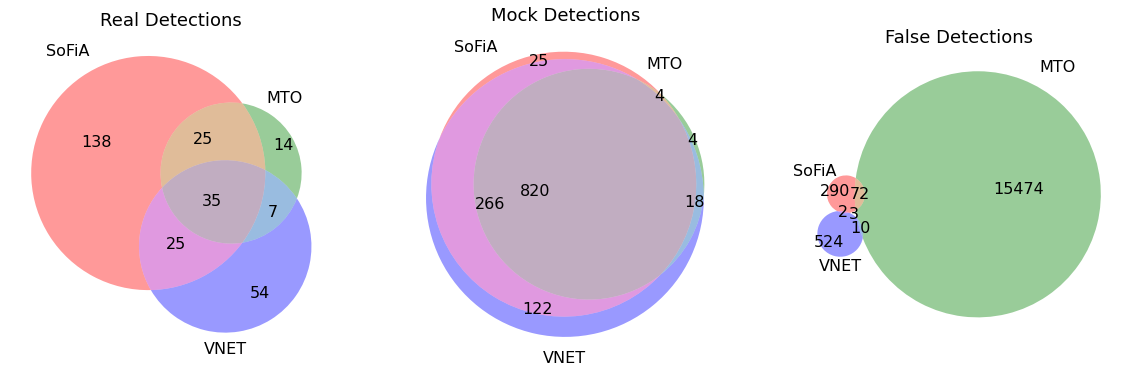

In [141]:
new_sof_test = new_sof[new_sof.mos_name.str.contains("1245")]
new_mto_test = new_mto[new_mto.mos_name.str.contains("1245")]
new_vnet_test = new_vnet[new_vnet.mos_name.str.contains("1245")]
set1 = set(new_sof_test[~new_sof_test.type.isnull()].mos_name + new_sof_test[~new_sof_test.type.isnull()].max_loc.astype(str))
set2 = set(new_mto_test[~new_mto_test.type.isnull()].mos_name + new_mto_test[~new_mto_test.type.isnull()].max_loc.astype(str))
set3 = set(new_vnet_test[~new_vnet_test.type.isnull()].mos_name + new_vnet_test[~new_vnet_test.type.isnull()].max_loc.astype(str))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, facecolor="white", figsize=(20, 20))
ax1.set_title("Real Detections", fontsize=18)
out = venn3([set1, set2, set3], ('SoFiA', 'MTO', 'VNET'), ax=ax1)
for text in out.set_labels:
    text.set_fontsize(16)
for text in out.subset_labels:
    text.set_fontsize(16)

set1 = set(new_sof_test[new_sof_test.true_positive_mocks].mos_name + new_sof_test[new_sof_test.true_positive_mocks].max_loc.astype(str))
set2 = set(new_mto_test[new_mto_test.true_positive_mocks].mos_name + new_mto_test[new_mto_test.true_positive_mocks].max_loc.astype(str))
set3 = set(new_vnet_test[new_vnet_test.true_positive_mocks].mos_name + new_vnet_test[new_vnet_test.true_positive_mocks].max_loc.astype(str))

ax2.set_title("Mock Detections", fontsize=18)
out = venn3([set1, set2, set3], ('SoFiA', 'MTO', 'VNET'), ax=ax2)
for text in out.set_labels:
    text.set_fontsize(16)
for text in out.subset_labels:
    text.set_fontsize(16)

set1 = set(new_sof_test[~new_sof_test.true_positive_mocks & new_sof_test.type.isnull()].mos_name + new_sof_test[~new_sof_test.true_positive_mocks & new_sof_test.type.isnull()].max_loc.astype(str))
set2 = set(new_mto_test[~new_mto_test.true_positive_mocks & new_mto_test.type.isnull()].mos_name + new_mto_test[~new_mto_test.true_positive_mocks & new_mto_test.type.isnull()].max_loc.astype(str))
set3 = set(new_vnet_test[~new_vnet_test.true_positive_mocks & new_vnet_test.type.isnull()].mos_name + new_vnet_test[~new_vnet_test.true_positive_mocks & new_vnet_test.type.isnull()].max_loc.astype(str))

ax3.set_title("False Detections", fontsize=18)
out = venn3([set1, set2, set3], ('SoFiA', 'MTO', 'VNET'), ax=ax3)
for text in out.set_labels:
    text.set_fontsize(16)
for text in out.subset_labels:
    text.set_fontsize(16)
plt.show()

/home/jbarkai/.local/lib/python3.8/site-packages/matplotlib_venn/_venn3.py:57: UserWarning: Circle B has zero area
  warnings.warn("Circle B has zero area")
/home/jbarkai/.local/lib/python3.8/site-packages/matplotlib_venn/_venn3.py:53: UserWarning: Circle A has zero area
  warnings.warn("Circle A has zero area")


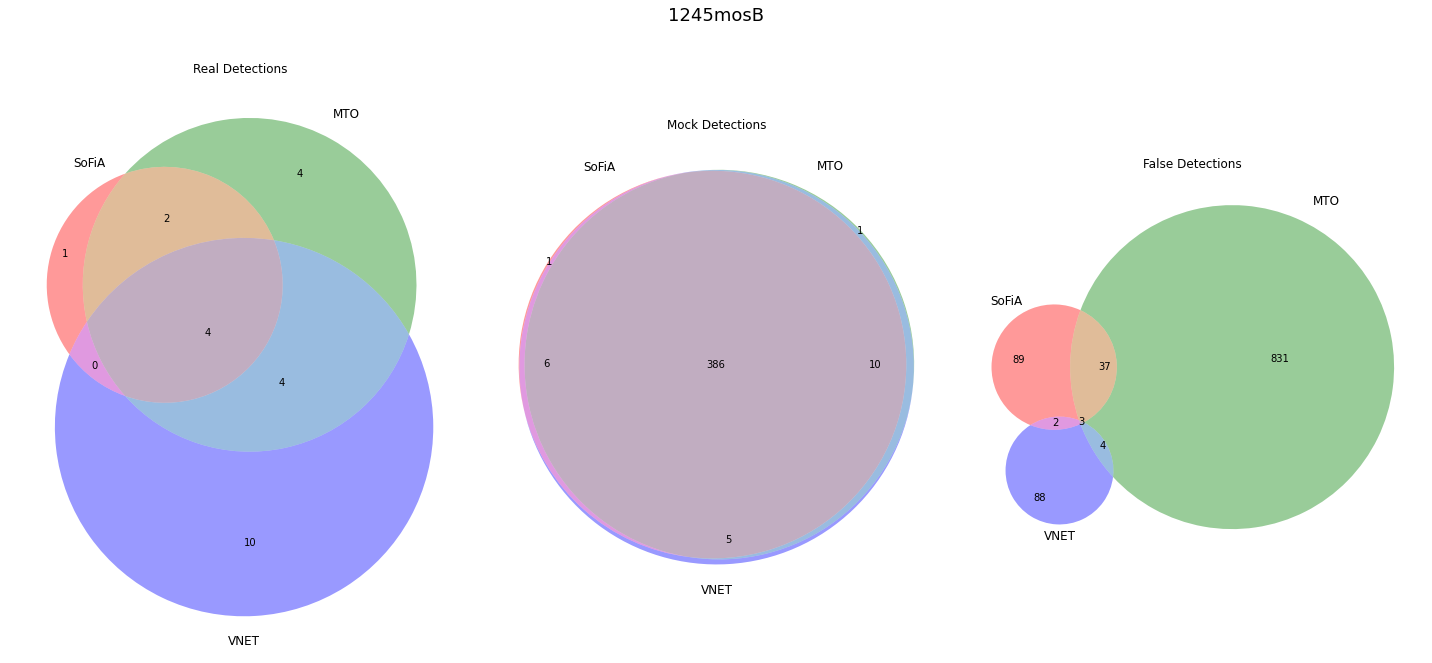

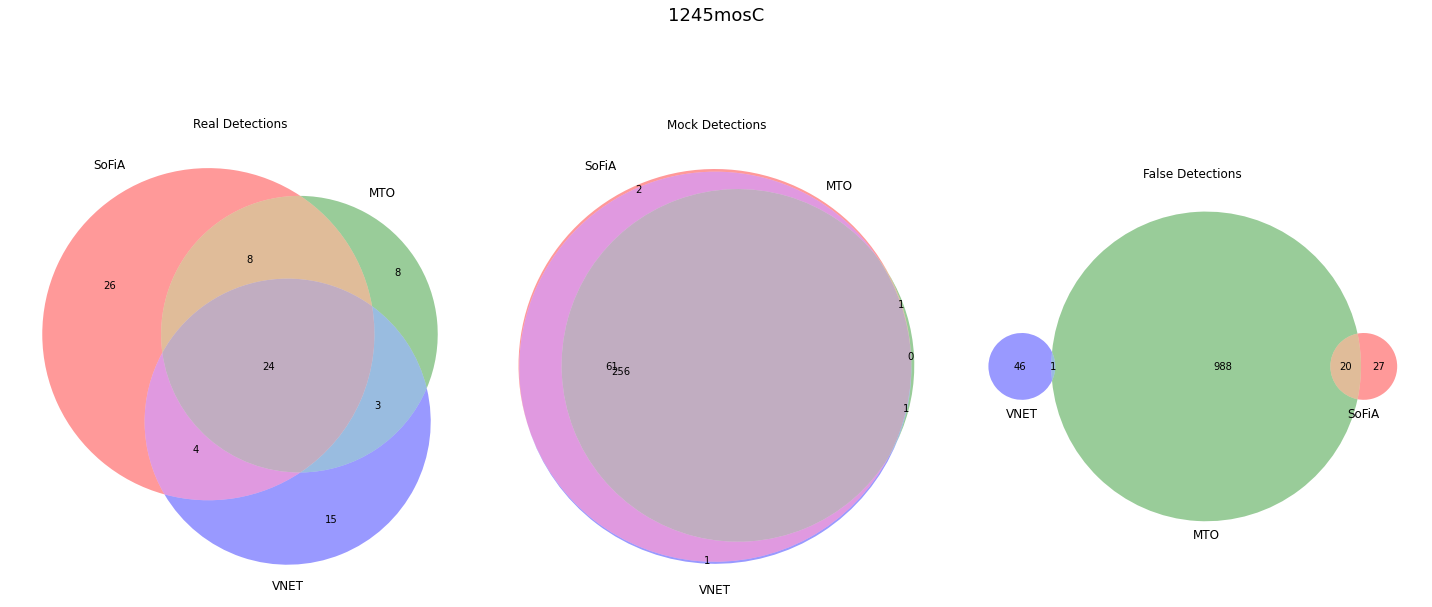

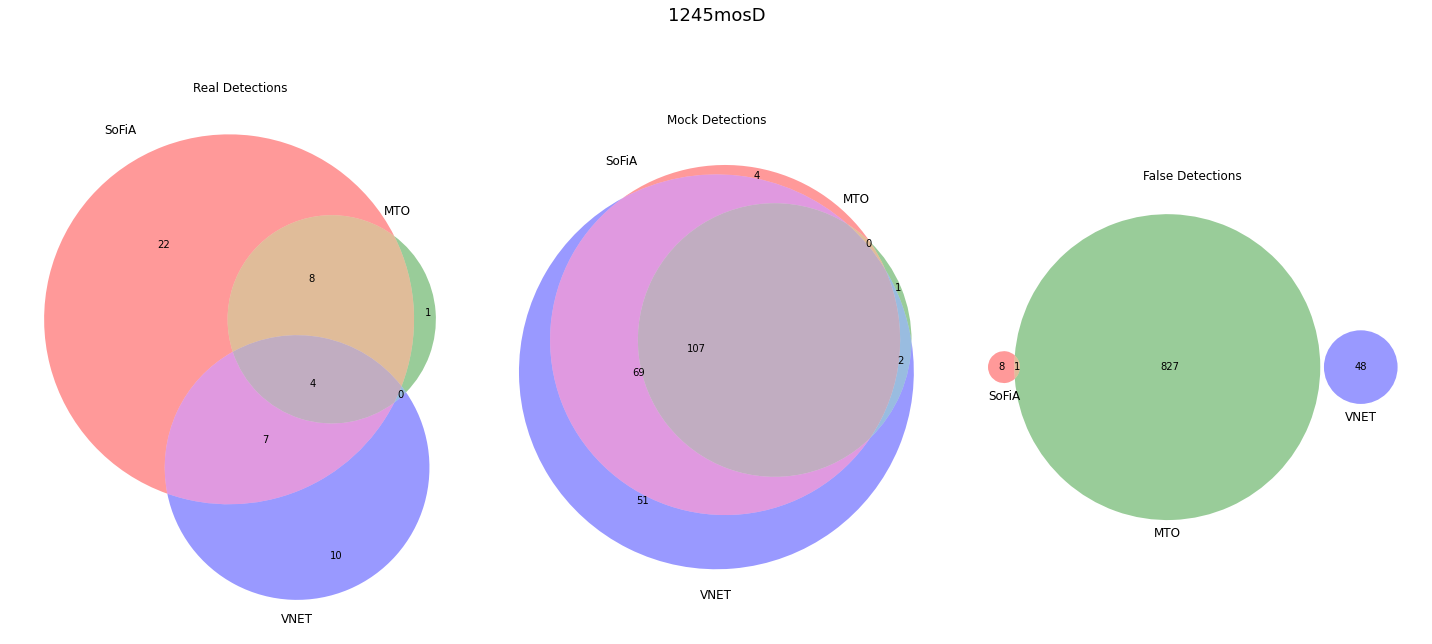

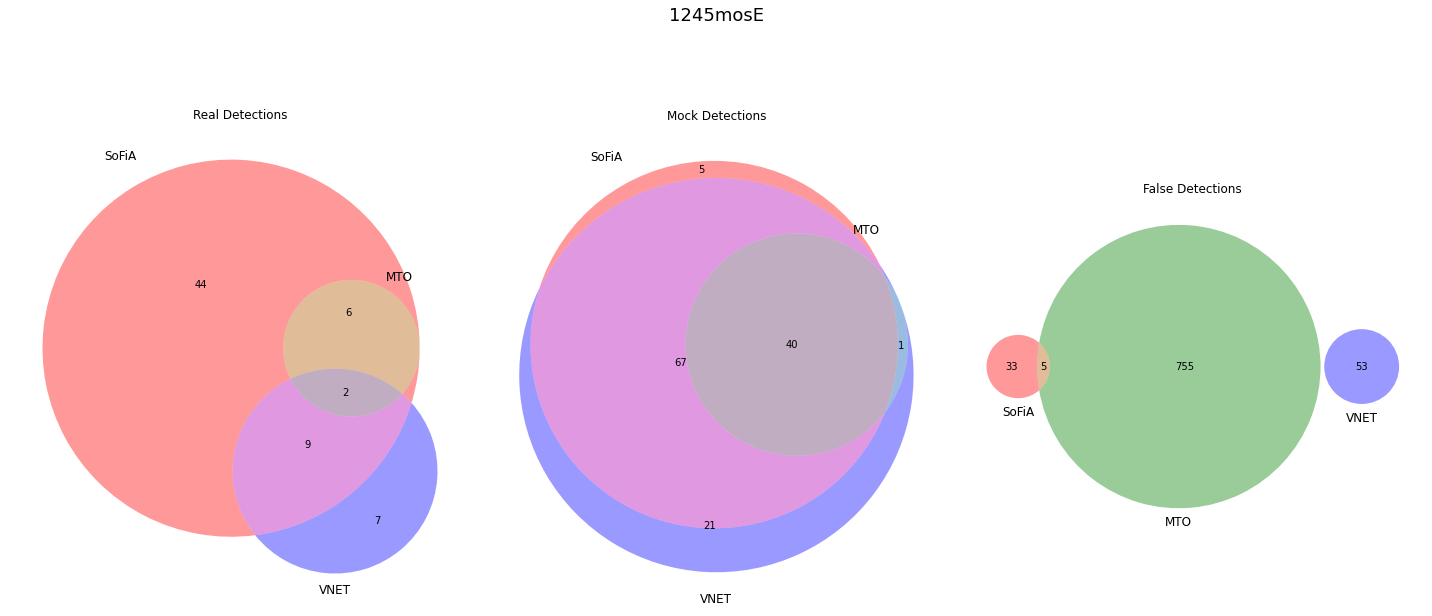

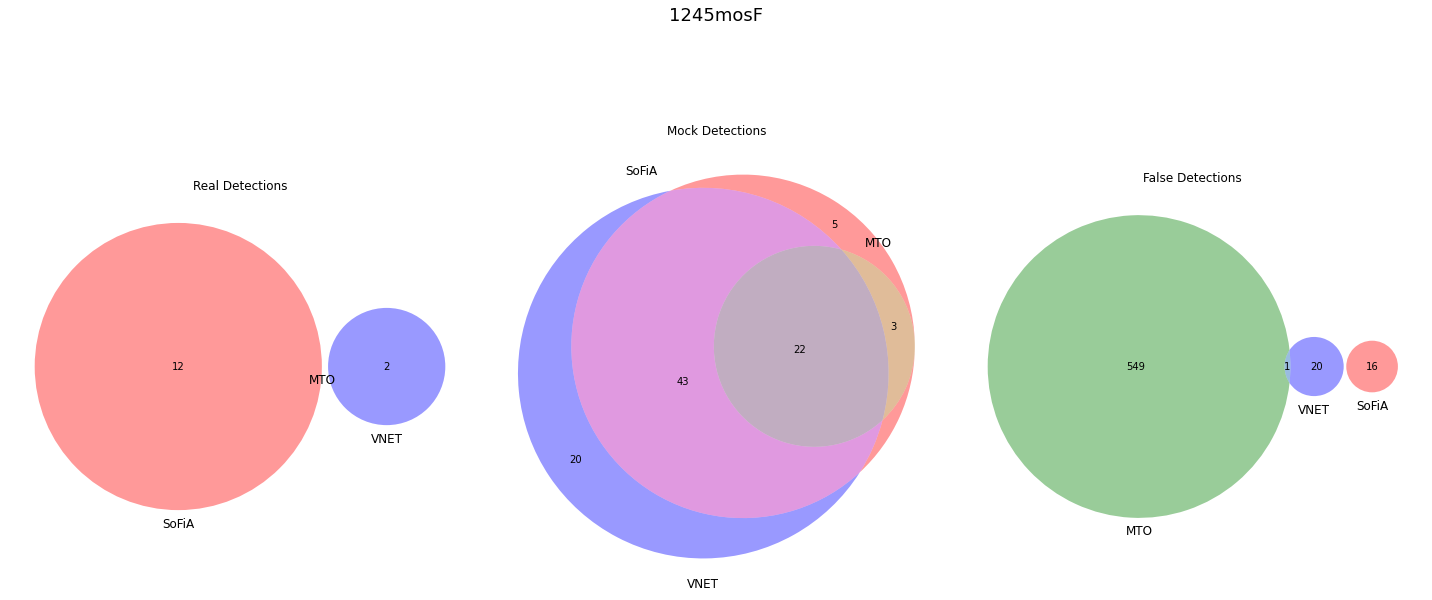

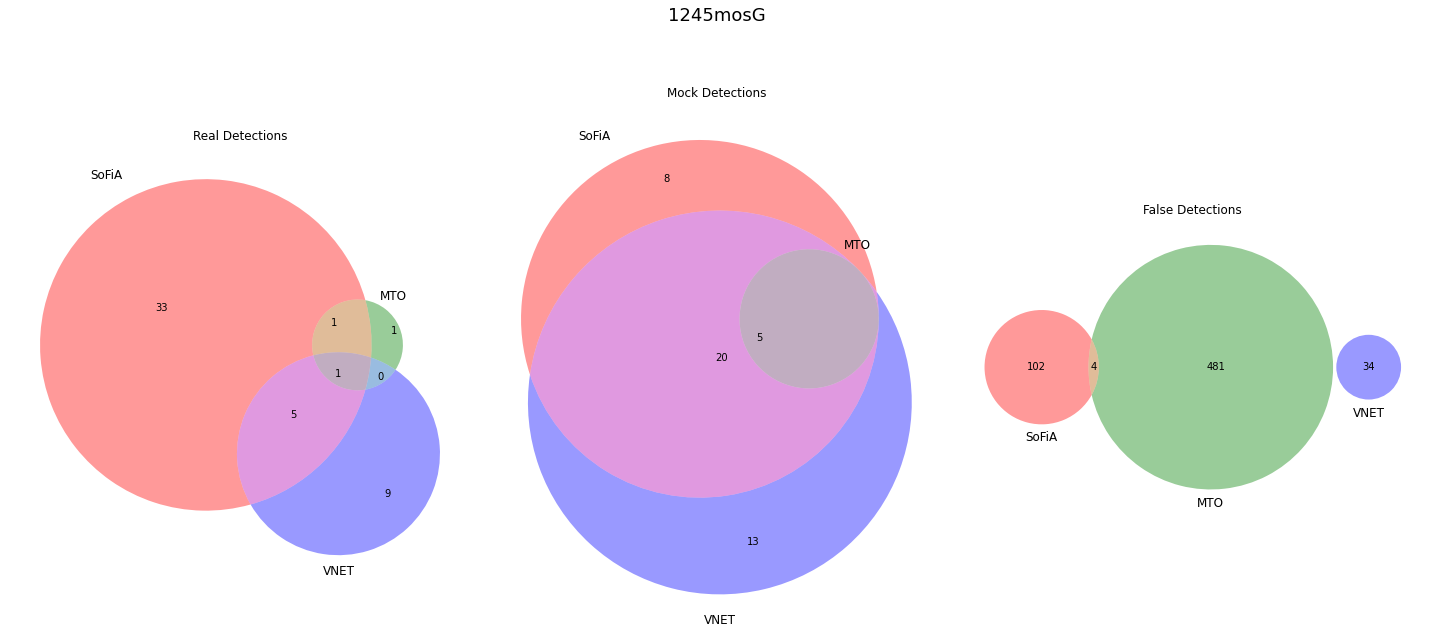

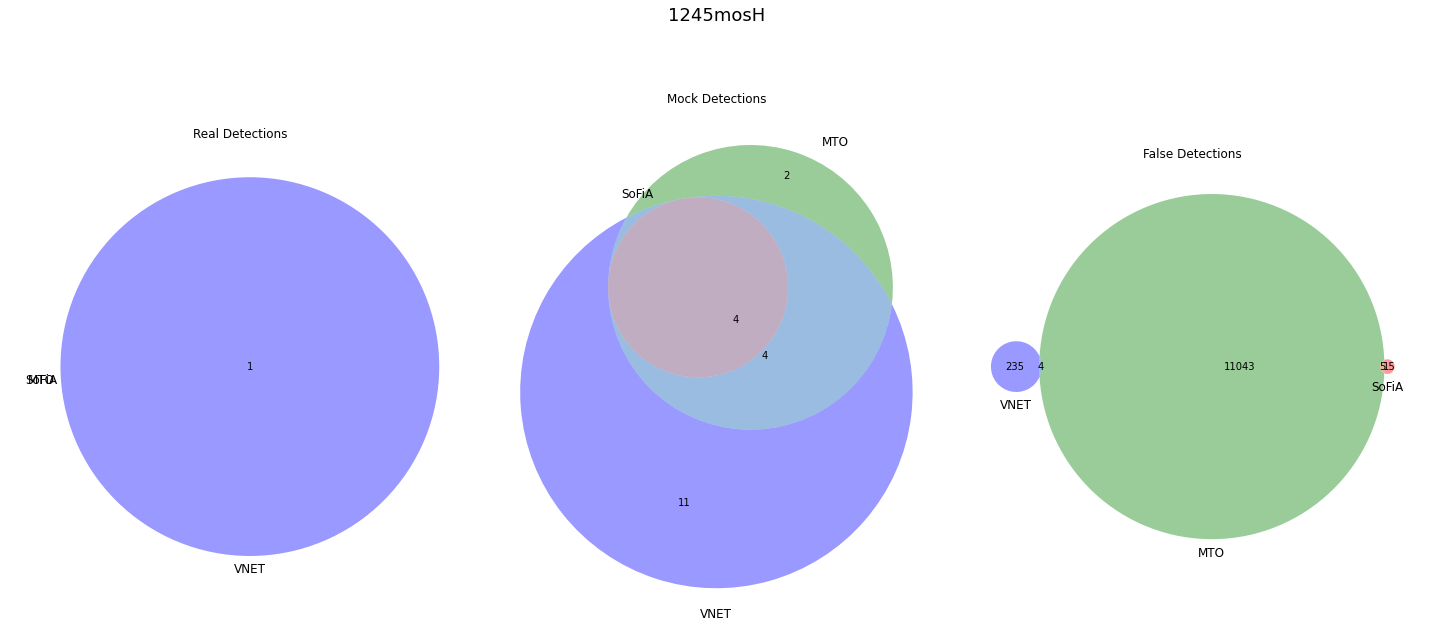

In [138]:
for mos_name in np.sort(new_sof_test.mos_name.unique()):
    set1 = set(new_sof_test[~new_sof_test.type.isnull() & (new_sof_test.mos_name==mos_name)].mos_name + new_sof_test[~new_sof_test.type.isnull() & (new_sof_test.mos_name==mos_name)].max_loc.astype(str))
    set2 = set(new_mto_test[~new_mto_test.type.isnull() & (new_mto_test.mos_name==mos_name)].mos_name + new_mto_test[~new_mto_test.type.isnull() & (new_mto_test.mos_name==mos_name)].max_loc.astype(str))
    set3 = set(new_vnet_test[~new_vnet_test.type.isnull() & (new_vnet_test.mos_name==mos_name)].mos_name + new_vnet_test[~new_vnet_test.type.isnull() & (new_vnet_test.mos_name==mos_name)].max_loc.astype(str))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, facecolor="white", figsize=(20, 20))
    ax1.set_title("Real Detections")
    venn3([set1, set2, set3], ('SoFiA', 'MTO', 'VNET'), ax=ax1)

    set1 = set(new_sof_test[new_sof_test.true_positive_mocks & (new_sof_test.mos_name==mos_name)].mos_name + new_sof_test[new_sof_test.true_positive_mocks & (new_sof_test.mos_name==mos_name)].max_loc.astype(str))
    set2 = set(new_mto_test[new_mto_test.true_positive_mocks & (new_mto_test.mos_name==mos_name)].mos_name + new_mto_test[new_mto_test.true_positive_mocks & (new_mto_test.mos_name==mos_name)].max_loc.astype(str))
    set3 = set(new_vnet_test[new_vnet_test.true_positive_mocks & (new_vnet_test.mos_name==mos_name)].mos_name + new_vnet_test[new_vnet_test.true_positive_mocks & (new_vnet_test.mos_name==mos_name)].max_loc.astype(str))

    ax2.set_title("Mock Detections")
    venn3([set1, set2, set3], ('SoFiA', 'MTO', 'VNET'), ax=ax2)

    set1 = set(new_sof_test[~new_sof_test.true_positive_mocks & new_sof_test.type.isnull() & (new_sof_test.mos_name==mos_name)].mos_name + new_sof_test[~new_sof_test.true_positive_mocks & new_sof_test.type.isnull() & (new_sof_test.mos_name==mos_name)].max_loc.astype(str))
    set2 = set(new_mto_test[~new_mto_test.true_positive_mocks & new_mto_test.type.isnull() & (new_mto_test.mos_name==mos_name)].mos_name + new_mto_test[~new_mto_test.true_positive_mocks & new_mto_test.type.isnull() & (new_mto_test.mos_name==mos_name)].max_loc.astype(str))
    set3 = set(new_vnet_test[~new_vnet_test.true_positive_mocks & new_vnet_test.type.isnull() & (new_vnet_test.mos_name==mos_name)].mos_name + new_vnet_test[~new_vnet_test.true_positive_mocks & new_vnet_test.type.isnull() & (new_vnet_test.mos_name==mos_name)].max_loc.astype(str))

    ax3.set_title("False Detections")
    venn3([set1, set2, set3], ('SoFiA', 'MTO', 'VNET'), ax=ax3)
    fig.tight_layout()
    fig.suptitle(mos_name, y=0.75, fontsize=18)

In [ ]:
real_gals = pd.merge(new_mto[~new_mto.type.isnull() & (new_mto.type!="notsure") & (new_mto.mos_name.str.contains("1245"))], pd.merge(new_sof[~new_sof.type.isnull() & (new_sof.type!="notsure") & (new_sof.mos_name.str.contains("1245"))], new_vnet[~new_vnet.type.isnull() & (new_vnet.type!="notsure") & (new_vnet.mos_name.str.contains("1245"))], on=['mos_name', 'max_loc'], how='outer'), on=['mos_name', 'max_loc'], how='outer')
overlap_real = real_gals[~real_gals.type_x.isnull() & ~real_gals.type_y.isnull() & ~real_gals.type.isnull()]

- MTO picks up by far most nonsense of all methods, particularly far away (mistaking noise for sources)
- VNET picks up more nonsense far away (mistaking noise for sources)
- SoFiA picks up more nonsense from nearby (from MW hi emission)
- VNET finds more mocks, then SoFiA, then MTO
- SoFiA finds more real galaxies (as expected, as VNET trains on mocks) and MTO the least
- Maybe SoFiA has some sort of bias or filtering that makes it struggle to find sources in the nearest cub

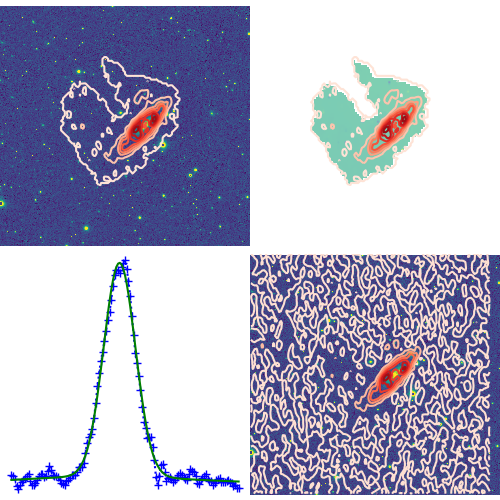

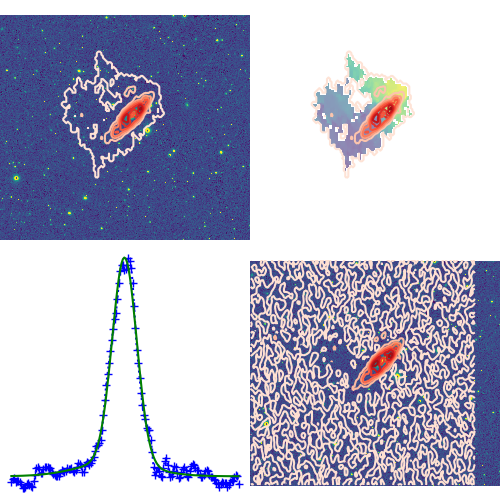

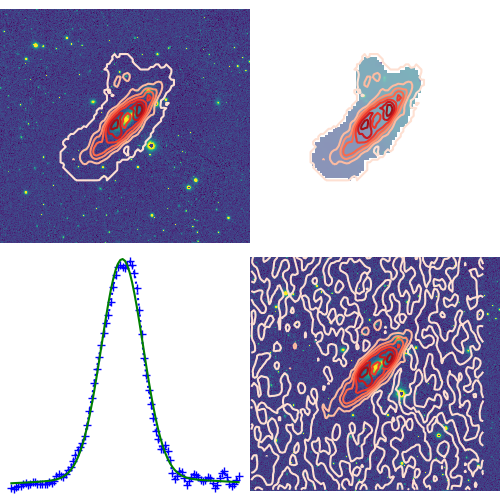

In [18]:
from PIL import Image
# print(overlap_df[(overlap_df.label_sof == 66) & (overlap_df.mos_name == "1245mosC")])
sof_image = Image.open('SOFIA_1245mosC_66.png')
mto_image = Image.open('MTO_1245mosC_996.png')
vnet_image = Image.open('VNET_1245mosC_283.png')
sof_image.show()
mto_image.show()
vnet_image.show()

## Investigate False detections

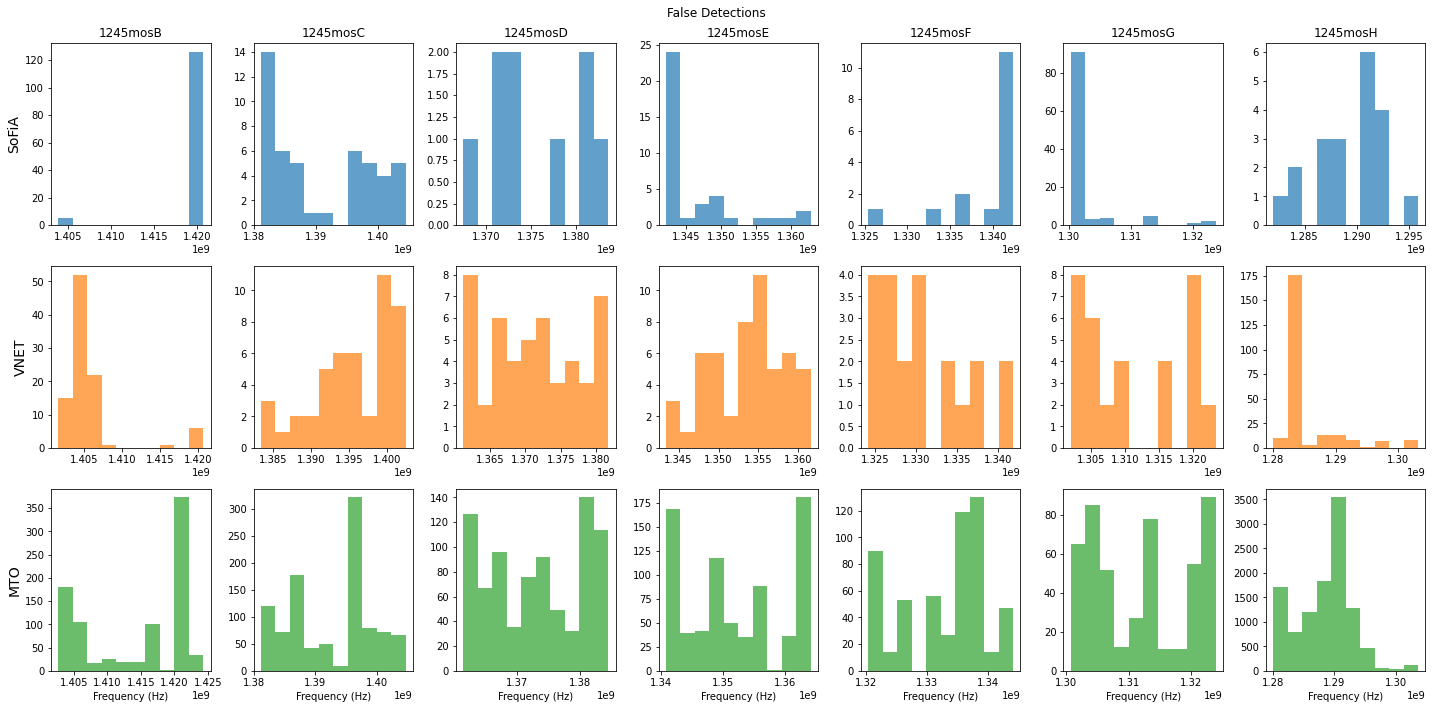

In [19]:
d_channels = 36621.09375*u.Hz
spec_range = {row.mos_name: np.arange(row.freq_1, row.freq_2, d_channels.value) for i, row in df.iterrows()}
new_sof['freq'] = [spec_range[row.mos_name][int(row['centroid-0'])] for i, row in new_sof.iterrows()]
new_vnet['freq'] = [spec_range[row.mos_name][int(row['centroid-0'])] for i, row in new_vnet.iterrows()]
new_mto['freq'] = [spec_range[row.mos_name][int(row['centroid-0'])] for i, row in new_mto.iterrows()]
fig, axes = plt.subplots(3, 7, figsize=(20, 10), facecolor='white')
fig.suptitle("False Detections")
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c']
for j, method in enumerate([new_sof, new_vnet, new_mto]):
    for i, mos_name in enumerate(np.sort(new_sof_test.mos_name.unique())):
            methodhist = method[(method.mos_name==mos_name) & method.type.isnull() & ~method.true_positive_mocks].freq
            axes[j][i].hist(methodhist, color=colors[j], alpha=0.7)
            if j == 0:
                axes[j][i].set_title(mos_name)
            elif j == 2:
                axes[j][i].set_xlabel("Frequency (Hz)")
#             axes[j][i].set_ylabel("Number of false detetcions")
axes[0][0].set_ylabel("SoFiA", fontsize=14)
axes[1][0].set_ylabel("VNET", fontsize=14)
axes[2][0].set_ylabel("MTO", fontsize=14)
fig.tight_layout()

- Emission of MW HI gas around 1420 MHz misdetected by SoFiA and MTO in 1245mosB
- Low number of real sources for 1245mosB because at higher frequencies you look at the very nearby universe and the volume that is surveyed by that spectral window becomes relatively small in terms of cubic Mega-parsecs.
- It could also be that one of the 40 beams in the mosaic has poor imaging quality.



## Invetigate Real detections
HI mass and spatial elongation (of test set)

/home/jbarkai/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jbarkai/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jbarkai/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jbarkai/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


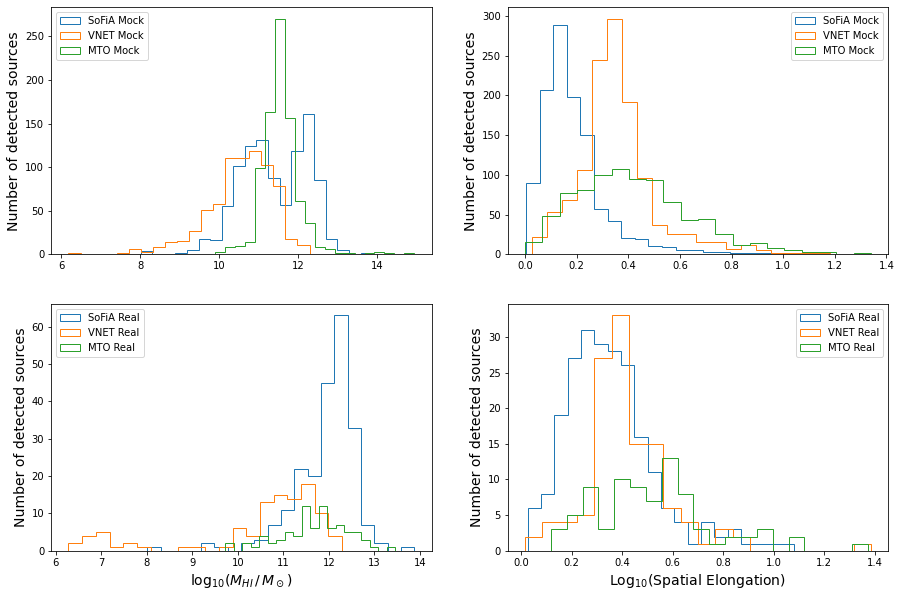

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(15,10))
sof_mock_phi = new_sof_test[new_sof_test.true_positive_mocks]
vnet_mock_phi = new_vnet_test[new_vnet_test.true_positive_mocks]
sof_real_phi = new_sof_test[~new_sof_test.type.isnull()]
vnet_real_phi = new_vnet_test[~new_vnet_test.type.isnull()]
mto_mock_phi = new_mto_test[new_mto_test.true_positive_mocks]
mto_real_phi = new_mto_test[~new_mto_test.type.isnull()]

ax1[0].hist(np.log10(sof_mock_phi.hi_mass), label="SoFiA Mock", bins=20, histtype='step')
ax1[0].hist(np.log10(vnet_mock_phi.hi_mass),label="VNET Mock", bins=20, histtype='step')
ax2[0].hist(np.log10(sof_real_phi.hi_mass), label="SoFiA Real", bins=20, histtype='step')
ax2[0].hist(np.log10(vnet_real_phi.hi_mass),label="VNET Real", bins=20, histtype='step')
ax2[0].hist(np.log10(mto_real_phi.hi_mass), label="MTO Real", bins=20, histtype='step')
ax1[0].hist(np.log10(mto_mock_phi.hi_mass),label="MTO Mock", bins=20, histtype='step')

ax2[0].set_xlabel(r'$\log_{10}(M_{HI}\,/\,M_\odot)$', fontsize=14)
ax1[0].set_ylabel("Number of detected sources", fontsize=14)
ax2[0].set_ylabel("Number of detected sources", fontsize=14)
ax1[0].legend()
ax2[0].legend()

ax1[1].hist(np.log10(sof_mock_phi.elongation), label="SoFiA Mock", bins=20, histtype='step')
ax1[1].hist(np.log10(vnet_mock_phi.elongation),label="VNET Mock", bins=20, histtype='step')
ax2[1].hist(np.log10(sof_real_phi.elongation), label="SoFiA Real", bins=20, histtype='step')
ax2[1].hist(np.log10(vnet_real_phi.elongation),label="VNET Real", bins=20, histtype='step')
ax2[1].hist(np.log10(mto_real_phi.elongation[np.isfinite(np.log10(mto_real_phi.elongation))]), label="MTO Real", bins=20, histtype='step')
ax1[1].hist(np.log10(mto_mock_phi.elongation)[np.isfinite(np.log10(mto_mock_phi.elongation))],label="MTO Mock", bins=20, histtype='step')

ax2[1].set_xlabel(r'Log$_{10}$(Spatial Elongation)', fontsize=14)
ax1[1].set_ylabel("Number of detected sources", fontsize=14)
ax2[1].set_ylabel("Number of detected sources", fontsize=14)
ax1[0].legend()
ax2[0].legend()
ax1[1].legend()
ax2[1].legend()

- SoFiA detects more massive galaxies, then MTO, then VNET
- MTO picks up more elongated sources, then VNET, then SoFiA

## Evaluate with real detections removed

In [21]:
new_sof_cross = new_sof[new_sof.type.isnull() | new_sof.true_positive_mocks]
new_vnet_cross = new_vnet[new_vnet.type.isnull() | new_vnet.true_positive_mocks]
new_mto_cross = new_mto[new_mto.type.isnull() | new_mto.true_positive_mocks]

In [22]:
full_sofia_df = make_eval_df(new_sof_cross, mask_cat_df)
full_mto_df = make_eval_df(new_mto_cross, mask_cat_df)
full_vnet_df = make_eval_df(new_vnet_cross, mask_cat_df)

/tmp/ipykernel_321/174318716.py:34: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


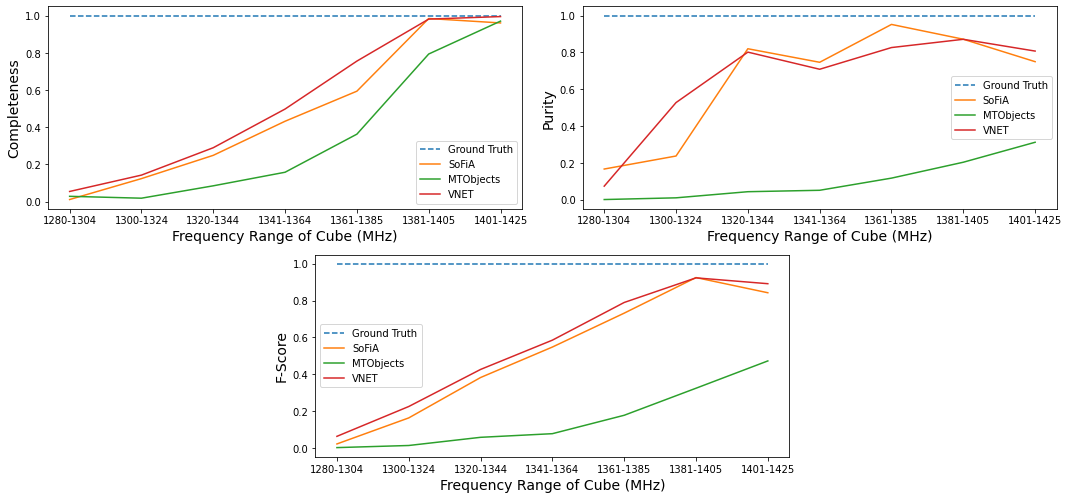

In [23]:
fig = plt.figure(constrained_layout=True, figsize=(15,10))
gs = fig.add_gridspec(3, 4)
ax1 = fig.add_subplot(gs[0, :2])
ax1.set_ylabel("Completeness", fontsize=14)
ax1.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax1.plot([1]*7, label="Ground Truth", linestyle="--")
sof = full_sofia_df[full_sofia_df.mos_name.str.contains("1245")].sort_values('freq_labels')
mto = full_mto_df[full_mto_df.mos_name.str.contains("1245")].sort_values('freq_labels')
vnet = full_vnet_df[full_vnet_df.mos_name.str.contains("1245")].sort_values('freq_labels')
ax1.plot(sof.freq_labels, sof.recall, label="SoFiA")
ax1.plot(mto.freq_labels, mto.recall, label="MTObjects")
ax1.plot(vnet.freq_labels, vnet.recall, label="VNET")
ax1.legend()

ax2 = fig.add_subplot(gs[0, 2:4])

ax2.set_ylabel("Purity", fontsize=14)
ax2.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax2.plot([1]*7, label="Ground Truth", linestyle="--")
ax2.plot(sof.freq_labels, sof.precision, label="SoFiA")
ax2.plot(mto.freq_labels, mto.precision, label="MTObjects")
ax2.plot(vnet.freq_labels, vnet.precision, label="VNET")
ax2.legend()

ax5 = fig.add_subplot(gs[1, 1:3])
ax5.set_ylabel("F-Score", fontsize=14)
ax5.plot([1]*7, label="Ground Truth", linestyle="--")
ax5.plot(sof.freq_labels, sof.f_score, label="SoFiA")
ax5.plot(mto.freq_labels, mto.f_score, label="MTObjects")
ax5.plot(vnet.freq_labels, vnet.f_score, label="VNET")
ax5.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax5.legend()

fig.tight_layout()

## Investigate quality of mock masks
For test set

/tmp/ipykernel_321/3057731717.py:22: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


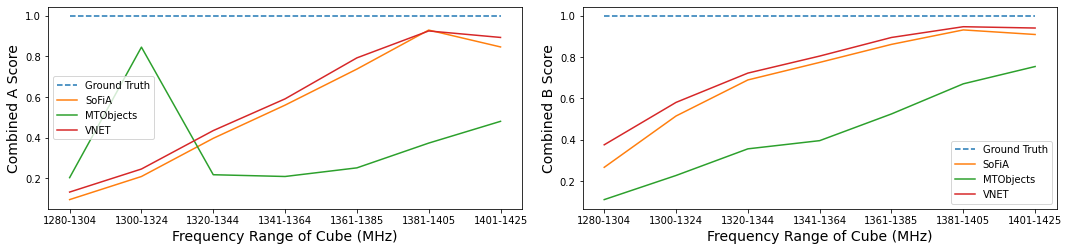

In [24]:
fig = plt.figure(constrained_layout=True, figsize=(15,10))
gs = fig.add_gridspec(3, 4)

ax3 = fig.add_subplot(gs[1, :2])
ax3.set_ylabel("Combined A Score", fontsize=14)
ax3.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax3.plot([1]*7, label="Ground Truth", linestyle="--")
ax3.plot(sof.freq_labels, sof.combined_one, label="SoFiA")
ax3.plot(mto.freq_labels, mto.combined_one, label="MTObjects")
ax3.plot(vnet.freq_labels, vnet.combined_one, label="VNET")
ax3.legend()

ax4 = fig.add_subplot(gs[1, 2:4])
ax4.set_ylabel("Combined B Score", fontsize=14)
ax4.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax4.plot([1]*7, label="Ground Truth", linestyle="--")
ax4.plot(sof.freq_labels, sof.combined_two, label="SoFiA")
ax4.plot(mto.freq_labels, mto.combined_two, label="MTObjects")
ax4.plot(vnet.freq_labels, vnet.combined_two, label="VNET")
ax4.legend()

fig.tight_layout()

- MTO is making tiny masks at 1245mosG for some reason

/tmp/ipykernel_321/1906184294.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[j][i].set_xticklabels(sof.index, rotation=45)


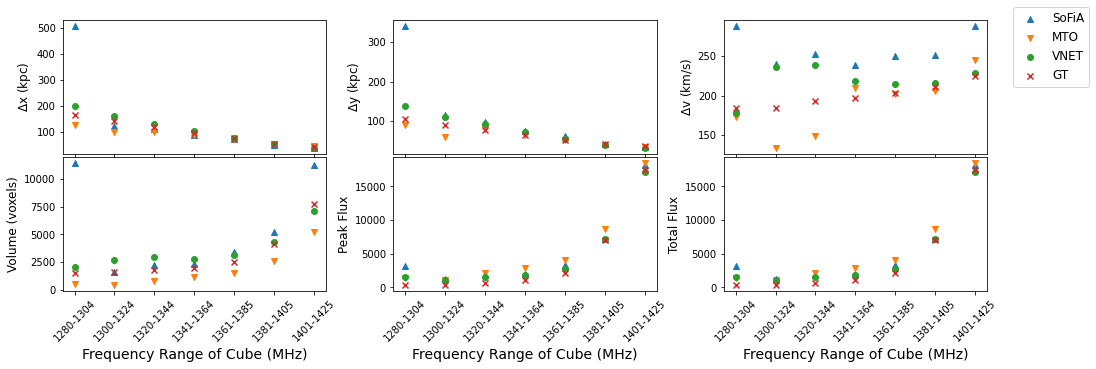

In [25]:
freq_labels = ['1279.96-1304', '1300.18-1324', '1320.39-1344', '1340.61-1364', '1360.82-1385', '1381.04-1405', '1401.25-1425']
fig, axes = plt.subplots(2, 3, figsize=(15,5), sharex=True) #, sharey=True, sharex=True)
# fig.suptitle("Mean properties galaxies detected in each cube", fontsize=15)
j = 0
labels = {"area": "Volume (voxels)", "peak_flux": "Peak Flux", "nx_kpc": r"$\Delta$x (kpc)", "ny_kpc": r"$\Delta$y (kpc)", "n_vel": r"$\Delta$v (km/s)", "tot_flux": "Total Flux"}
for i, col in enumerate(["nx_kpc", "ny_kpc", "n_vel", "area", "peak_flux", "tot_flux"]):
    if i == 3:
        j += 1
    sof = pd.merge(df[['mos_name', 'freq_labels', 'freq_1']], sofia_cat_df[sofia_cat_df.true_positive_mocks & sofia_cat_df.mos_name.str.contains("1245")], on="mos_name", how="right").groupby('freq_labels').mean()

    if i >= 3:
        i = i - 3
        axes[j][i].set_xticklabels(sof.index, rotation=45)
        axes[j][i].set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
    mto = pd.merge(df[['mos_name', 'freq_labels', 'freq_1']], mto_cat_df[mto_cat_df.true_positive_mocks & mto_cat_df.mos_name.str.contains("1245")], on="mos_name", how="right").groupby('freq_labels').mean()
    vnet = pd.merge(df[['mos_name', 'freq_labels', 'freq_1']], vnet_cat_df[vnet_cat_df.true_positive_mocks & vnet_cat_df.mos_name.str.contains("1245")], on="mos_name", how="right").groupby('freq_labels').mean()
    mask = pd.merge(df[['mos_name', 'freq_labels', 'freq_1']], mask_cat_df[mask_cat_df.mos_name.str.contains("1245")], on="mos_name", how="right").groupby('freq_labels').mean()
    axes[j][i].scatter(sof.index, sof[col], label="SoFiA", marker='^')
    axes[j][i].scatter(mto.index, mto[col], label="MTO", marker='v')
    axes[j][i].scatter(vnet.index, vnet[col], label="VNET", marker='o')
    axes[j][i].scatter(mask.index, mask[col], label="GT", marker='x')
    axes[j][i].set_ylabel(labels[col], fontsize=12)

axes[0][2].legend(loc=(1.1, 0.5), fontsize=12)
fig.tight_layout(pad=0)

- SoFiA picking up a lot of nonsense in 1245mosB due to MW emission and nonsense at far cubes, need more rigourous way to cross-match than just max-loc
- $\Delta v$ is the most poorly estimated by all, getting worse with distance except last one because so few detected by VNET and MTO

# Experiment 2
- Train machine learning to classify false positives

Create classified catalog

In [26]:
sof_cat = new_sof[['mos_name', 'area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'true_positive_mocks', 'hi_mass', 'type']]
sof_cat["Class"] = 0
sof_cat.loc[sof_cat.true_positive_mocks | ~sof_cat.type.isnull(), "Class"] = 1
sof_cat["method"] = "sofia"
sof_cat = sof_cat[['mos_name', 'method', 'area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'hi_mass', 'Class']]
mto_cat = new_mto[['mos_name', 'area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'true_positive_mocks', 'hi_mass', 'type']]
mto_cat["Class"] = 0
mto_cat.loc[mto_cat.true_positive_mocks | ~mto_cat.type.isnull(), "Class"] = 1
mto_cat["method"] = "mto"
mto_cat = mto_cat[['mos_name', 'method', 'area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'hi_mass', 'Class']]
vnet_cat = new_vnet[['mos_name', 'area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'true_positive_mocks', 'hi_mass', 'type']]
vnet_cat["Class"] = 0
vnet_cat.loc[vnet_cat.true_positive_mocks | ~vnet_cat.type.isnull(), "Class"] = 1
vnet_cat["method"] = "vnet"
vnet_cat = vnet_cat[['mos_name', 'method', 'area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'hi_mass', 'Class']]
full_cat = sof_cat.append(vnet_cat).append(mto_cat)

/tmp/ipykernel_321/4167785538.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sof_cat["Class"] = 0
/home/jbarkai/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/tmp/ipykernel_321/4167785538.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

## Train ML to identify tps
- train and evaluate ML methods with train set (1353)
- use best model to predict class of test set (1245)
- remove detections from catalogs for evaluation that were predicted to be false

In [30]:
full_cat = full_cat[~full_cat.elongation.isnull() & ~full_cat.hi_mass.isnull() & np.isfinite(full_cat.elongation)]
x_train = full_cat[full_cat.mos_name.str.contains("1353")][['area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'hi_mass']]
x_test = full_cat[full_cat.mos_name.str.contains("1245")][['area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'hi_mass']]
y_train = full_cat[full_cat.mos_name.str.contains("1353")].Class.astype(int)
y_test = full_cat[full_cat.mos_name.str.contains("1245")].Class.astype(int)

In [31]:
tree_model = tree.DecisionTreeClassifier(max_depth=3, class_weight='balanced')
rf = RandomForestClassifier(class_weight='balanced') 
svm_model = SVC(probability=True, class_weight='balanced')
knn_model = KNeighborsClassifier(n_neighbors=3)
bayes_model = GaussianNB()
models = [tree_model, rf, svm_model, knn_model, bayes_model]
model_names = ["Decision Tree", "Random Forrests", "Support Vector Classification", "K Nearest Neighbours", "Gaussian Naive Bayes"]

In [33]:
sof_precision = []
mto_precision = []
vnet_precision = []
sof_recall = []
mto_recall = []
vnet_recall = []

for model, model_name in zip(models, model_names):
    model.fit(x_train, y_train)
    ml_new_sof = new_sof_test[~new_sof_test.elongation.isnull() & ~new_sof_test.hi_mass.isnull() & np.isfinite(new_sof_test.elongation)].copy(deep=True)
    ml_new_sof["prediction"] = model.predict(ml_new_sof[['area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
           'nx_kpc', 'ny_kpc', 'hi_mass']])
    ml_new_sof = ml_new_sof[ml_new_sof.prediction == 1]
    ml_new_sof = ml_new_sof[ml_new_sof.type.isnull()]

    ml_new_mto = new_mto_test[~new_mto_test.elongation.isnull() & ~new_mto_test.hi_mass.isnull() & np.isfinite(new_mto_test.elongation)].copy(deep=True)
    ml_new_mto["prediction"] = model.predict(ml_new_mto[['area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
           'nx_kpc', 'ny_kpc', 'hi_mass']])
    ml_new_mto = ml_new_mto[ml_new_mto.prediction == 1]
    ml_new_mto = ml_new_mto[ml_new_mto.type.isnull()]

    ml_new_vnet = new_vnet_test[~new_vnet_test.elongation.isnull() & ~new_vnet_test.hi_mass.isnull() & np.isfinite(new_vnet_test.elongation)].copy(deep=True)
    ml_new_vnet["prediction"] = model.predict(ml_new_vnet[['area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
           'nx_kpc', 'ny_kpc', 'hi_mass']])
    ml_new_vnet = ml_new_vnet[ml_new_vnet.prediction == 1]
    ml_new_vnet = ml_new_vnet[ml_new_vnet.type.isnull()]
    new_full_sofia_df = make_eval_df(ml_new_sof, mask_cat_df)
    new_full_mto_df = make_eval_df(ml_new_mto, mask_cat_df)
    new_full_vnet_df = make_eval_df(ml_new_vnet, mask_cat_df)
    sof_precision.append(new_full_sofia_df[new_full_sofia_df.mos_name.str.contains("1245")].sort_values('freq_labels').precision)
    mto_precision.append(new_full_mto_df[new_full_mto_df.mos_name.str.contains("1245")].sort_values('freq_labels').precision)
    vnet_precision.append(new_full_vnet_df[new_full_vnet_df.mos_name.str.contains("1245")].sort_values('freq_labels').precision)
    
    sof_recall.append(new_full_sofia_df[new_full_sofia_df.mos_name.str.contains("1245")].sort_values('freq_labels').recall)
    mto_recall.append(new_full_mto_df[new_full_mto_df.mos_name.str.contains("1245")].sort_values('freq_labels').recall)
    vnet_recall.append(new_full_vnet_df[new_full_vnet_df.mos_name.str.contains("1245")].sort_values('freq_labels').recall)

/tmp/ipykernel_321/1752268989.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][0].set_xticklabels(sof.freq_labels, rotation=45)
/tmp/ipykernel_321/1752268989.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][1].set_xticklabels(mto.freq_labels, rotation=45)
/tmp/ipykernel_321/1752268989.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][2].set_xticklabels(vnet.freq_labels, rotation=45)
/tmp/ipykernel_321/1752268989.py:36: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


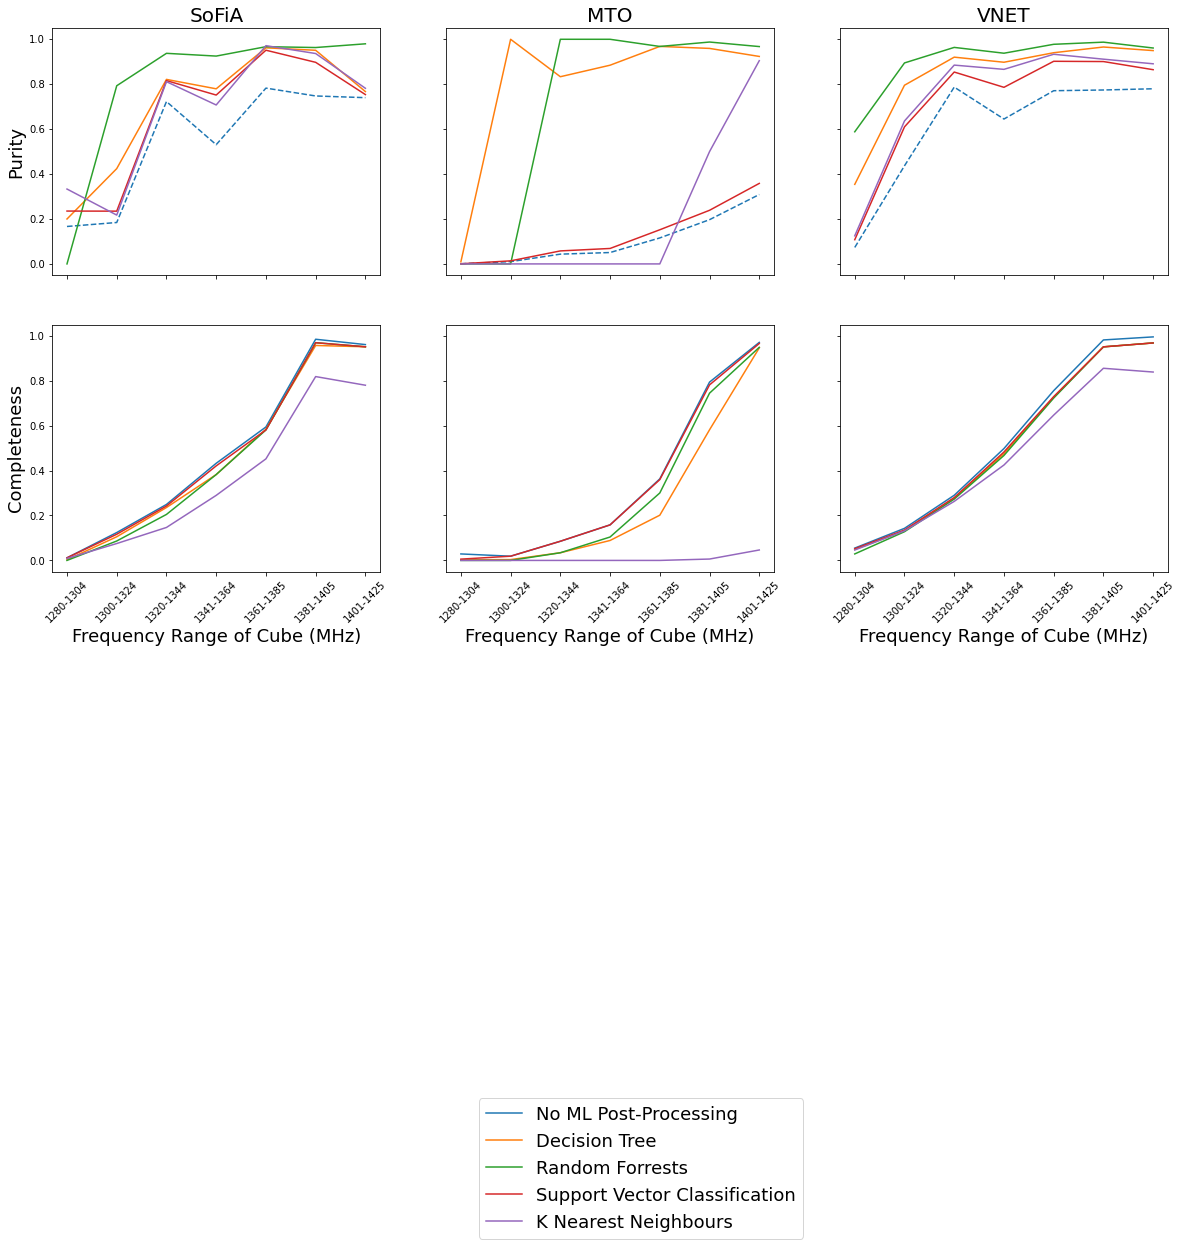

In [239]:
model_names = ['Decision Tree', 'Random Forrests', 'Support Vector Classification', 'K Nearest Neighbours', 'Gaussian Naive Bayes']
fig, axes = plt.subplots(2, 3, figsize=(20,10), sharey=True, sharex=True)
axes[0][0].set_ylabel("Purity", fontsize=18)
axes[1][0].set_ylabel("Completeness", fontsize=18)
axes[1][0].set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=18)
axes[1][1].set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=18)
axes[1][2].set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=18)

sof = full_sofia_df[full_sofia_df.mos_name.str.contains("1245")].sort_values('freq_labels')
mto = full_mto_df[full_mto_df.mos_name.str.contains("1245")].sort_values('freq_labels')
vnet = full_vnet_df[full_vnet_df.mos_name.str.contains("1245")].sort_values('freq_labels')
axes[0][0].plot(sof.freq_labels, sof.precision, label="No ML Post-Processing", linestyle='--')
axes[0][1].plot(mto.freq_labels, mto.precision, label="No ML Post-Processing", linestyle='--')
axes[0][2].plot(vnet.freq_labels, vnet.precision, label="No ML Post-Processing", linestyle='--')


axes[1][0].plot(sof.freq_labels, sof.recall, label="No ML Post-Processing")
axes[1][1].plot(mto.freq_labels, mto.recall, label="No ML Post-Processing")
axes[1][2].plot(vnet.freq_labels, vnet.recall, label="No ML Post-Processing")

for i, model_name in zip(range(len(sof_precision)-1), model_names):
    axes[0][0].plot(sof.freq_labels, sof_precision[i], label=model_name)
    axes[0][1].plot(mto.freq_labels, mto_precision[i], label=model_name)
    axes[0][2].plot(vnet.freq_labels, vnet_precision[i], label=model_name)
    axes[1][0].plot(sof.freq_labels, sof_recall[i], label=model_name)
    axes[1][1].plot(mto.freq_labels, mto_recall[i], label=model_name)
    axes[1][2].plot(vnet.freq_labels, vnet_recall[i], label=model_name)

plt.legend(loc=(-1.1, -2.7), fontsize=18, borderaxespad=-10)
axes[0][0].set_title("SoFiA", fontsize=20)
axes[0][1].set_title("MTO", fontsize=20)
axes[0][2].set_title("VNET", fontsize=20)
axes[1][0].set_xticklabels(sof.freq_labels, rotation=45)
axes[1][1].set_xticklabels(mto.freq_labels, rotation=45)
axes[1][2].set_xticklabels(vnet.freq_labels, rotation=45)
fig.tight_layout()

1. RF:
    - best purity
    - good completeness
    - struggles with furthest cube for MTO and SoFiA
2. DT:
    - 2nd best purity
    - only struggles with furthest cube for MTO
    - MTO completeness drops slightly
4. SVC:
    - purity barely improves
    - completeness unchanged
4. KNN:
    - drops completeness
    - struggles with MTO
    
** Can't really say anything for when no detections (hense sometimes purity and completeness both 0)

# Experiment 3
- create 'real' catalog of all real sources cross-matched that are not 'notsure'
- take majority vote and overlay on masks
- retrain VNET

In [60]:
real_gals = pd.merge(new_mto[~new_mto.type.isnull() & (new_mto.type!="notsure") & (new_mto.mos_name.str.contains("1245"))], pd.merge(new_sof[~new_sof.type.isnull() & (new_sof.type!="notsure") & (new_sof.mos_name.str.contains("1245"))], new_vnet[~new_vnet.type.isnull() & (new_vnet.type!="notsure") & (new_vnet.mos_name.str.contains("1245"))], on=['mos_name', 'max_loc'], how='outer'), on=['mos_name', 'max_loc'], how='outer')
overlap_real = real_gals[~real_gals.type_x.isnull() & ~real_gals.type_y.isnull() & ~real_gals.type.isnull()]
atleast1_overlap = real_gals[(~real_gals.type_x.isnull() & ~real_gals.type_y.isnull())| (~real_gals.type.isnull() & ~real_gals.type_y.isnull()) | (~real_gals.type_x.isnull() & ~real_gals.type.isnull())]

print(len(real_gals), "real detections from training set")
print(len(atleast1_overlap), " detected by at least 2 methods")
print(len(overlap_real), " detected by all methods")

243 real detections from training set
86  detected by at least 2 methods
30  detected by all methods
